# **MRI Brain Alzheimer Classification - EfficientNet Model**

**Clone Dataset from GitHub**

In [1]:
# Clone repository from GitHub
# !git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification

# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Brain_Alzheimer_Classification


**Import Packages**

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
import gc
import subprocess

**Import Internal Functions**

In [3]:
from models import def_models
from utils import utils_funcs
from utils import optuna_search

**Device Definition**

In [4]:
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()
gc.collect()
utils_funcs.open_nvitop()

torch.cuda.is_available(): True
device: cuda:0


**Load Dataset**

In [5]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

**Normalize and Rescale the Dataset**

In [ ]:
# train_set, validation_set, test_set = utils_funcs.prepare_datasets(train_set, validation_set, test_set)
# torch.cuda.empty_cache()

**Model Definition and Initialization**

In [7]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

# Load a pre-trained EfficientNet-B4 model
EfficientNet_backbone_model = torchvision.models.efficientnet_b0(pretrained=True)

# Freeze EfficientNet-B0 layers
for param in EfficientNet_backbone_model.parameters():
    param.requires_grad = False
    
# Unfreeze the last classifier layer to allow training
for param in EfficientNet_backbone_model.features[-4:].parameters():
    param.requires_grad = True

# Create EfficientNet-B4 model with FC layers before the output
model = def_models.EfficientNet(EfficientNet_backbone=EfficientNet_backbone_model, output_channels=output_channels).to(device)

**Model Statistics**

In [8]:
model_name = type(model).__name__
print("Model", model_name, "Statistics:")
summary(model, (input_channels, input_height, input_width))

Model EfficientNet Statistics:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      Ba

**Set Hyper-Parameters Using Optuna**

In [9]:
load_existing_hyperparams = True

if load_existing_hyperparams:
    # Load hyper-parameters (relevant if optuna has already used)
    optuna_params_path = f'./checkpoints/optuna_params/{model_name}/EfficientNet_0.8901.json'
    with open(optuna_params_path, 'r') as file:
        hyperparams = json.load(file)
else:
    # Find optimal hyper-parameters using optuna
    torch.cuda.empty_cache()
    hyperparams = optuna_search.optuna_param_search(model_name="EfficientNet", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=10, device=device, transfer_learning=True)

print(hyperparams)

{'lr': 0.0008763123646325776, 'optimizer': 'RMSprop', 'batch_size': 256, 'scheduler': 'StepLR'}


In [10]:
# Set hyper-parameters
batch_size = hyperparams['batch_size']
learning_rate = hyperparams['lr']
optimizer_name = hyperparams['optimizer']
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
# optimizer = getattr(torch.optim, optimizer_name)(model.fc.parameters(), lr=learning_rate)
num_epochs = 30
scheduler = hyperparams['scheduler']
scheduler = StepLR(optimizer, 10, 0.1, verbose=True) if scheduler == "StepLR" else CosineAnnealingLR(optimizer, num_epochs, verbose=True)
criterion = nn.CrossEntropyLoss()

**Data Augmentations**

In [11]:
augmentations = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.1),
    K.RandomVerticalFlip(p=0.1),
    K.RandomRotation(degrees=10, p=0.1),
    K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.1),
    K.RandomBrightness(brightness=(0.8, 1.2), p=0.1),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.1),
    K.RandomGamma(gamma=(0.9, 1.1), p=0.1),
    K.RandomSharpness(p=0.1),
    same_on_batch=False
)

**Create Data Loaders**

In [12]:
# Data loading and shuffling
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

**Train Model**

In [13]:
load_existing_params = False
train_loaded_model = False

if load_existing_params:
    model_path = './checkpoints/EfficientNet_163902_13102024/EfficientNet_172348_13102024_train_0.1178_val_0.1789.pth'
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['net'])
    if (train_loaded_model):
        epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer, scheduler, augmentations, use_amp=True)
else:
    epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer, scheduler, augmentations, use_amp=True)

Created training session directory: ./checkpoints/EfficientNet_230733_14102024
Training model: EfficientNet on cuda:0


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch: 1 | Training Loss: 0.9183 | Training Accuracy: 67.700% | Validation Loss: 0.8323 | Validation Accuracy: 66.943% | Epoch Time: 136.87 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch: 2 | Training Loss: 0.4671 | Training Accuracy: 71.887% | Validation Loss: 0.7905 | Validation Accuracy: 69.238% | Epoch Time: 123.72 secs


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch: 3 | Training Loss: 0.3805 | Training Accuracy: 92.212% | Validation Loss: 0.3540 | Validation Accuracy: 86.572% | Epoch Time: 124.19 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch: 4 | Training Loss: 0.3045 | Training Accuracy: 94.495% | Validation Loss: 0.3344 | Validation Accuracy: 89.697% | Epoch Time: 124.32 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch: 5 | Training Loss: 0.2543 | Training Accuracy: 94.360% | Validation Loss: 0.3143 | Validation Accuracy: 89.307% | Epoch Time: 138.79 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_230733_14102024/EfficientNet_231821_14102024_train_0.2543_val_0.3143.pth


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch: 6 | Training Loss: 0.2047 | Training Accuracy: 89.417% | Validation Loss: 0.6154 | Validation Accuracy: 82.129% | Epoch Time: 123.39 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch: 7 | Training Loss: 0.1754 | Training Accuracy: 98.572% | Validation Loss: 0.2948 | Validation Accuracy: 93.066% | Epoch Time: 128.72 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch: 8 | Training Loss: 0.1546 | Training Accuracy: 93.921% | Validation Loss: 0.4469 | Validation Accuracy: 87.695% | Epoch Time: 131.05 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch: 9 | Training Loss: 0.1353 | Training Accuracy: 98.181% | Validation Loss: 0.3259 | Validation Accuracy: 91.602% | Epoch Time: 133.37 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch: 10 | Training Loss: 0.1267 | Training Accuracy: 99.707% | Validation Loss: 0.1826 | Validation Accuracy: 95.264% | Epoch Time: 137.09 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_230733_14102024/EfficientNet_232914_14102024_train_0.1267_val_0.1826.pth


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch: 11 | Training Loss: 0.0964 | Training Accuracy: 99.988% | Validation Loss: 0.1530 | Validation Accuracy: 97.070% | Epoch Time: 135.68 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch: 12 | Training Loss: 0.0827 | Training Accuracy: 99.988% | Validation Loss: 0.1281 | Validation Accuracy: 97.412% | Epoch Time: 137.68 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch: 13 | Training Loss: 0.0688 | Training Accuracy: 100.000% | Validation Loss: 0.1319 | Validation Accuracy: 97.510% | Epoch Time: 140.13 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch: 14 | Training Loss: 0.0716 | Training Accuracy: 100.000% | Validation Loss: 0.1270 | Validation Accuracy: 97.314% | Epoch Time: 144.88 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Epoch: 15 | Training Loss: 0.0680 | Training Accuracy: 100.000% | Validation Loss: 0.1108 | Validation Accuracy: 97.656% | Epoch Time: 145.98 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_230733_14102024/EfficientNet_234059_14102024_train_0.0680_val_0.1108.pth


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch: 16 | Training Loss: 0.0641 | Training Accuracy: 100.000% | Validation Loss: 0.1250 | Validation Accuracy: 97.412% | Epoch Time: 147.85 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch: 17 | Training Loss: 0.0652 | Training Accuracy: 100.000% | Validation Loss: 0.1354 | Validation Accuracy: 97.412% | Epoch Time: 146.53 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch: 18 | Training Loss: 0.0589 | Training Accuracy: 100.000% | Validation Loss: 0.1058 | Validation Accuracy: 97.852% | Epoch Time: 149.17 secs


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch: 19 | Training Loss: 0.0534 | Training Accuracy: 100.000% | Validation Loss: 0.1025 | Validation Accuracy: 97.461% | Epoch Time: 157.90 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch: 20 | Training Loss: 0.0578 | Training Accuracy: 100.000% | Validation Loss: 0.1159 | Validation Accuracy: 97.754% | Epoch Time: 137.08 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_230733_14102024/EfficientNet_235318_14102024_train_0.0578_val_0.1159.pth


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch: 21 | Training Loss: 0.0533 | Training Accuracy: 100.000% | Validation Loss: 0.1008 | Validation Accuracy: 97.705% | Epoch Time: 154.55 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Epoch: 22 | Training Loss: 0.0487 | Training Accuracy: 100.000% | Validation Loss: 0.1059 | Validation Accuracy: 97.900% | Epoch Time: 154.68 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch: 23 | Training Loss: 0.0524 | Training Accuracy: 100.000% | Validation Loss: 0.1095 | Validation Accuracy: 98.096% | Epoch Time: 143.09 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch: 24 | Training Loss: 0.0545 | Training Accuracy: 100.000% | Validation Loss: 0.1115 | Validation Accuracy: 97.656% | Epoch Time: 139.78 secs


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch: 25 | Training Loss: 0.0548 | Training Accuracy: 100.000% | Validation Loss: 0.1175 | Validation Accuracy: 97.803% | Epoch Time: 141.87 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_230733_14102024/EfficientNet_000532_15102024_train_0.0548_val_0.1175.pth


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch: 26 | Training Loss: 0.0471 | Training Accuracy: 100.000% | Validation Loss: 0.1103 | Validation Accuracy: 97.803% | Epoch Time: 155.08 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch: 27 | Training Loss: 0.0483 | Training Accuracy: 100.000% | Validation Loss: 0.1090 | Validation Accuracy: 97.900% | Epoch Time: 132.85 secs


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch: 28 | Training Loss: 0.0499 | Training Accuracy: 100.000% | Validation Loss: 0.1227 | Validation Accuracy: 97.656% | Epoch Time: 134.15 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch: 29 | Training Loss: 0.0490 | Training Accuracy: 100.000% | Validation Loss: 0.1010 | Validation Accuracy: 97.998% | Epoch Time: 138.18 secs


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch: 30 | Training Loss: 0.0504 | Training Accuracy: 100.000% | Validation Loss: 0.1141 | Validation Accuracy: 97.705% | Epoch Time: 141.99 secs
==> Saving model ...
Saved as ./checkpoints/EfficientNet_230733_14102024/EfficientNet_001714_15102024_train_0.0504_val_0.1141.pth


**Results**

In [14]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 96.091%


<Figure size 800x600 with 0 Axes>

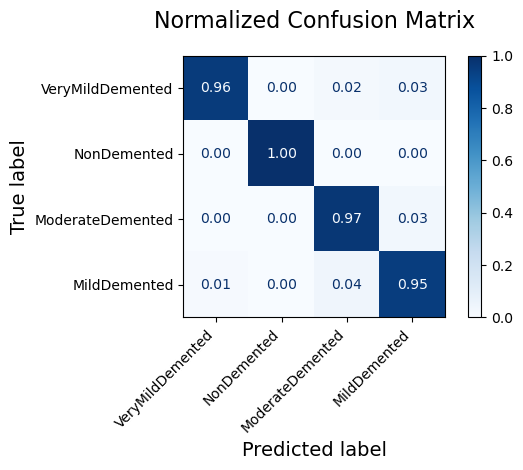

In [15]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_normalized_confusion_matrix(testloader, model, class_names, device, model_name)

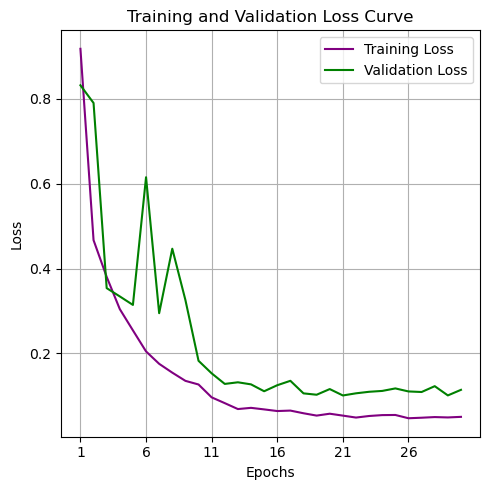

In [16]:
utils_funcs.plot_loss_curve(epoch_train_losses, epoch_validation_losses, num_epochs, model_name)

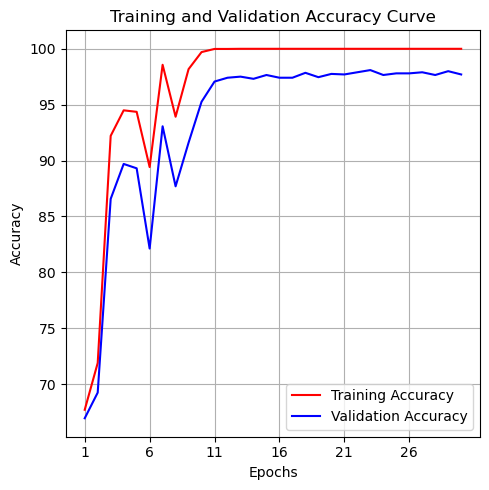

In [17]:
utils_funcs.plot_accuracy_curve(epoch_train_accuracies, epoch_validation_accuracies, num_epochs, model_name)